# train_test_split

In [1]:
import pandas as pd

from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.model_selection import train_test_split as tts

In [2]:
df=pd.DataFrame(load_diabetes().data, columns=load_diabetes().feature_names)

df['target']=load_diabetes().target

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [3]:
X=df.drop('target', axis=1)
y=df.target

In [4]:
X_train, X_test, y_train, y_test = tts(X, y)

In [5]:
modelo=RFR()

modelo.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [6]:
y_pred=modelo.predict(X_test)  # solar_test

In [7]:
modelo.score(X_test, y_test)

0.5442224530023105

### Pipeline

In [8]:
def get_data():
    
    df=pd.DataFrame(load_diabetes().data, columns=load_diabetes().feature_names)
    df['target']=load_diabetes().target
    
    return df

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
def clean_data(df):
    
    df_temp=df.drop(columns=['target'])
    
    df_temp=pd.DataFrame(StandardScaler().fit_transform(df_temp), columns=load_diabetes().feature_names)
    
    df_temp['target']=df.target
    
    return df_temp

In [11]:
def model_data(df):
    
    X=df.drop('target', axis=1)
    y=df.target
    
    return RFR().fit(X,y).predict(X)

In [12]:
def main():
    df=get_data()  # extrae data
    
    df2=clean_data(df) # limpia/procesa data
    
    y_pred=model_data(df2)  # entrena modelo y hace predicciom
    
    print (y_pred[:10])

In [13]:
main()

[184.08  73.8  148.23 198.32 115.74 101.78 113.41  95.44 119.43 256.4 ]


# Diamonds (Encoding)

In [14]:
import pandas as pd
import xgboost as xgb

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split 


import warnings
warnings.simplefilter('ignore')

In [15]:
diamond=pd.read_csv('data/diamonds_train.csv')
diamond.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


In [16]:
X=diamond.drop(columns=['price'])
y=diamond.price

In [17]:
# Ordinal Encoder

clarity={'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4, 'VVS2':5, 'VVS1':6, 'IF':7}
cut={'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4}
color={'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6}

In [18]:
def labeling(s, dic):
    return dic[s]

In [19]:
X.clarity=X.clarity.apply(lambda x: labeling(x, clarity))
X.cut=X.cut.apply(lambda x: labeling(x, cut))
X.color=X.color.apply(lambda x: labeling(x, color))
X=X.drop(columns=['table'])

In [20]:
X.head()

,carat,cut,color,clarity,depth,x,y,z
0,1.21,3,0,3,62.4,6.83,6.79,4.25
1,0.32,2,2,3,63.0,4.35,4.38,2.75
2,0.71,0,3,4,65.5,5.62,5.53,3.65
3,0.41,1,6,2,63.8,4.68,4.72,3.00
4,1.02,4,3,2,60.5,6.55,6.51,3.95


In [21]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
space ={'n_estimators': hp.quniform('n_estimators', 10, 1000, 25),
        'learning_rate': hp.uniform('learning_rate', 0.0001, 1.0),
        'max_depth': hp.quniform('x_max_depth', 4, 16, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
    }

In [39]:
def objetivo(space):
    #print(space)
    clf = xgb.XGBRegressor(n_estimators =int(space['n_estimators']),
                           learning_rate = space['learning_rate'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'],
                           objective='reg:squarederror')

    eval_set=[(X_train, y_train), (X_test, y_test)]

    clf.fit(X_train, y_train,
            eval_set=eval_set, eval_metric="rmse", verbose=False)

    y_pred = clf.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**(0.5)

    return {'loss':rmse, 'status': STATUS_OK }

In [24]:
trials_reg = Trials()

best = fmin(fn=objetivo,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_reg)

100%|██████████| 10/10 [03:59<00:00, 23.94s/it, best loss: 530.3952027159391]


In [25]:
modelo=xgb.XGBRegressor(n_estimators=int(best['n_estimators']), 
                        x_gamma=best['x_gamma'],
                        learning_rate=best['learning_rate'],
                        x_max_depth= best['x_max_depth'], 
                        x_min_child= best['x_min_child'], 
                        x_reg_lambda=best['x_reg_lambda'], 
                        x_subsample= best['x_subsample'],
                        objective='reg:squarederror')

modelo.fit(X_train, y_train)
y_pred=modelo.predict(X_test)

print ('RMSE: {}'.format(mean_squared_error(y_test, y_pred)**(0.5)))

RMSE: 559.2099757766266


In [26]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [27]:
# Label encoding

X=diamond.drop(columns=['price'])
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,6.55,6.51,3.95


In [28]:
X[['cut', 'color','clarity']]=X[['cut', 'color','clarity']].apply(LabelEncoder().fit_transform)

X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,1.21,3,6,5,62.4,58.0,6.83,6.79,4.25
1,0.32,4,4,5,63.0,57.0,4.35,4.38,2.75
2,0.71,0,3,4,65.5,55.0,5.62,5.53,3.65
3,0.41,1,0,2,63.8,56.0,4.68,4.72,3.00
4,1.02,2,3,2,60.5,59.0,6.55,6.51,3.95


In [29]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

trials_reg = Trials()
best = fmin(fn=objetivo,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_reg)

modelo=xgb.XGBRegressor(n_estimators=int(best['n_estimators']), 
                        x_gamma=best['x_gamma'],
                        learning_rate=best['learning_rate'],
                        x_max_depth= best['x_max_depth'], 
                        x_min_child= best['x_min_child'], 
                        x_reg_lambda=best['x_reg_lambda'], 
                        x_subsample= best['x_subsample'],
                        objective='reg:squarederror')

modelo.fit(X_train, y_train)
y_pred=modelo.predict(X_test)

print ('RMSE: {}'.format(mean_squared_error(y_test, y_pred)**(0.5)))

100%|██████████| 10/10 [02:14<00:00, 13.45s/it, best loss: 543.8667265453812]
RMSE: 615.0448522356095


In [30]:
# One Hot encoding

X=diamond.drop(columns=['price'])

X=pd.get_dummies(X)

X.head()

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1.21,62.4,58.0,6.83,6.79,4.25,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
1,0.32,63.0,57.0,4.35,4.38,2.75,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.71,65.5,55.0,5.62,5.53,3.65,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.41,63.8,56.0,4.68,4.72,3.00,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.02,60.5,59.0,6.55,6.51,3.95,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [31]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

trials_reg = Trials()
best = fmin(fn=objetivo,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_reg)

modelo=xgb.XGBRegressor(n_estimators=int(best['n_estimators']), 
                        x_gamma=best['x_gamma'],
                        learning_rate=best['learning_rate'],
                        x_max_depth= best['x_max_depth'], 
                        x_min_child= best['x_min_child'], 
                        x_reg_lambda=best['x_reg_lambda'], 
                        x_subsample= best['x_subsample'],
                        objective='reg:squarederror')

modelo.fit(X_train, y_train)
y_pred=modelo.predict(X_test)

print ('RMSE: {}'.format(mean_squared_error(y_test, y_pred)**(0.5)))

100%|██████████| 10/10 [07:00<00:00, 42.06s/it, best loss: 546.8433670129418]
RMSE: 680.8179914582764


In [32]:
X=diamond.drop(columns=['price'])

X=pd.get_dummies(X, drop_first=True)

X.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1.21,62.4,58.0,6.83,6.79,4.25,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0.32,63.0,57.0,4.35,4.38,2.75,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,0.71,65.5,55.0,5.62,5.53,3.65,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.41,63.8,56.0,4.68,4.72,3.00,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.02,60.5,59.0,6.55,6.51,3.95,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [33]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

trials_reg = Trials()
best = fmin(fn=objetivo,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_reg)

modelo=xgb.XGBRegressor(n_estimators=int(best['n_estimators']), 
                        x_gamma=best['x_gamma'],
                        learning_rate=best['learning_rate'],
                        x_max_depth= best['x_max_depth'], 
                        x_min_child= best['x_min_child'], 
                        x_reg_lambda=best['x_reg_lambda'], 
                        x_subsample= best['x_subsample'],
                        objective='reg:squarederror')

modelo.fit(X_train, y_train)
y_pred=modelo.predict(X_test)

print ('RMSE: {}'.format(mean_squared_error(y_test, y_pred)**(0.5)))

100%|██████████| 10/10 [06:21<00:00, 38.15s/it, best loss: 584.0133868222493]
RMSE: 763.6682937873562


# OOP

In [34]:
from lightgbm import LGBMRegressor


lgbmr=LGBMRegressor
xgbr=xgb.XGBRegressor

In [40]:
class Opti:
    
    def __init__(self, model):
        
        self.space ={'n_estimators': hp.quniform('n_estimators', 10, 1000, 25),
                     'learning_rate': hp.uniform('learning_rate', 0.0001, 1.0),
                     'max_depth': hp.quniform('x_max_depth', 4, 16, 1),
                     'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
                     'subsample': hp.uniform ('x_subsample', 0.7, 1),
                     'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)}
        
        
        self.best_params_={}
        
        self.model=model
    
    def objetivo(self):

        clf = self.model(n_estimators =int(self.space['n_estimators']),
                        learning_rate = self.space['learning_rate'],
                        max_depth = int(self.space['max_depth']),
                        min_child_weight = self.space['min_child_weight'],
                        subsample = self.space['subsample'],
                        reg_lambda = self.space['reg_lambda'],
                        objective='reg:squarederror')

        eval_set=[(X_train, y_train), (X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=eval_set, eval_metric="rmse", verbose=False)

        y_pred = clf.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred)**(0.5)

        return {'loss':rmse, 'status': STATUS_OK }


        
    
    def fit(self):
        trials_reg = Trials()
        self.best_params_ = fmin(fn=self.objetivo,
                                space=self.space,
                                algo=tpe.suggest,
                                max_evals=2,
                                trials=trials_reg)
 
        
        return self
    
    def predict(self):
        
        modelo=self.model(n_estimators=int(self.best_params_['n_estimators']), 
                         learning_rate=self.best_params_['learning_rate'],
                         x_max_depth= self.best_params_['x_max_depth'], 
                         x_min_child= self.best_params_['x_min_child'], 
                         x_reg_lambda=self.best_params_['x_reg_lambda'], 
                         x_subsample= self.best_params_['x_subsample'],
                         objective='reg:squarederror')

        modelo.fit(X_train, y_train)
        y_pred=modelo.predict(X_test)
        
        return y_pred

In [41]:
Opti(xgbr).fit()

100%|██████████| 2/2 [01:11<00:00, 35.95s/it, best loss: 585.7523729368322]


In [42]:
Opti(xgbr).fit().predict()

100%|██████████| 2/2 [01:26<00:00, 43.01s/it, best loss: 641.0939418491507]


array([2737.3584, 2453.7004,  893.2761, ..., 3036.2356, 3806.359 ,
       7615.1133], dtype=float32)

In [43]:
Opti(lgbmr).fit()

100%|██████████| 2/2 [01:01<00:00, 30.71s/it, best loss: 806.4481906064536]


# Guardar Sklearn

In [44]:
from sklearn import svm
from sklearn import datasets


clf = svm.SVC()
X, y= datasets.load_iris(return_X_y=True)
clf.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
clf.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [46]:
import pickle

s=pickle.dump(clf, open('data/svc_model.p', 'wb'))

 

clf2 = pickle.load(open('data/svc_model.p', 'rb'))

clf2.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# AB Testing

+ impresiones  : visitas a la web
+ conversiones : las ventas a través de la web

+ tasa de conversion: conversiones/impresiones

![](data/abtest.jpg)

![](data/multitest.png)

In [321]:
from bayes_func import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from mpmath import betainc



class BayesianABTest:
    
    def __init__(self, impr, conv):
        
        self.impr=impr   # impresiones nº
        self.conv=conv   # conversiones nº
        
        # manera frecuentista
        self.cr=[self.conv[i]/self.impr[i] for i in range(len(self.conv))] # tasas de conversion (0-1)
        
        #manera bayesiana
        self.betas=[beta(self.conv[i]+1, self.impr[i]-self.conv[i]+1) for i in range(len(self.conv))]
    
    
    
    def stats(self):  # buscar el mejor y comparar con el control
        #return 'Proba: {}'.format(calc_prob(*self.betas[::-1])*100)
        return 'Proba: {}'.format(calc_prob(self.betas[-1], self.betas[0])*100)
        
    
    def plot_bayes(self):
        plot(self.betas, ['V_{}'.format(i) for i in range(len(self.betas))])
        plt.show()
        
        '''
        val=[np.random.beta(self.conv[i]+1, self.impr[i]-self.conv[i]+1, 50000) for i in range(len(self.conv))]

        vals=np.vstack(val).T

        g=sns.jointplot(x=val[0], y=val[1], kind='kde', n_levels=15)
        g.ax_joint.plot([0.0015, 0.004], [0.0015, 0.004])
        plt.show();
        '''
        
        
    def what_if(self, threshold):  # cual es la prob de ser superior al threshold (tasa de conversion)
        return [betainc(self.conv[i]+1, self.impr[i]-self.conv[i]+1, threshold, 1, regularized=True) for i in range(len(self.conv))]

In [322]:
impr=[16500, 17000, 12000]

conv=[30, 50, 60]

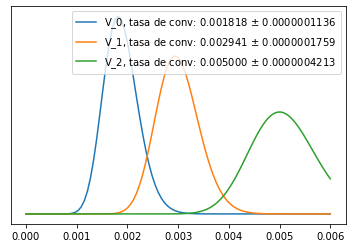

In [323]:
BayesianABTest(impr, conv).plot_bayes()

In [324]:
BayesianABTest(impr, conv).stats()

'Proba: 99.99986437668689'

In [325]:
BayesianABTest(impr, conv).what_if(0.003)

[mpf('0.0019421426114151557'),
 mpf('0.48112566853812544'),
 mpf('0.99991092822519978')]

# ArgParsing

In [ ]:
import argparse


def suma(a,b):        # funcion suma
    return a+b


def resta(a,b):       # funcion resta
    return a-b


def multi(a,b):       # funcion multiplicacion
    return a*b


def divi(a,b):        # funcion division
    return a/b





def parse():
    parser=argparse.ArgumentParser()                 # analizador de argumentos

    grupo=parser.add_mutually_exclusive_group()      # grupo mutuamente excluyente (solo una operacion)

    grupo.add_argument('-s', '--sum', help='Realiza la suma de dos numeros.', action='store_true')           # action guarda el argumento
    grupo.add_argument('-r', '--rest', help='Realiza la resta de dos numeros.', action='store_true')
    grupo.add_argument('-m', '--mult', help='Realiza la multiplicacion de dos numeros.', action='store_true')
    grupo.add_argument('-d', '--div', help='Realiza la division de dos numeros.', action='store_true')


    parser.add_argument('n1', help='Primer numero de la operacion.', type=float)
    parser.add_argument('n2', help='Segundo numero de la operacion.', type=float)


    return parser.parse_args()



def main():           # funcion principal

    args=parse()


    # opciones

    if args.sum: print ('El resultado de sumar {} con {} es {}'.format(args.n1, args.n2, (suma(args.n1, args.n2))))

    elif args.rest: print ('El resultado de resta {} con {} es {}'.format(args.n1, args.n2, (resta(args.n1, args.n2))))

    elif args.mult: print ('El resultado de multiplicar {} con {} es {}'.format(args.n1, args.n2, (multi(args.n1, args.n2))))

    elif args.div: print ('El resultado de dividir {} con {} es {}'.format(args.n1, args.n2, (divi(args.n1, args.n2))))

    else: print ('Error: se requiere un argumento para realizar la accion.')


if __name__=='__main__':
    main()

